In [1]:
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # input layer should be of shape [:, NVCHANNELS, 1]
    # NVCHANNELS: number of velocity bins
    
    NVCHANNELS=128
    
    input_layer = tf.reshape(features["x"], [-1, NVCHANNELS, 1])
    
    # Convolutional Layer #1
    # Computes 32 features using a 8 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 128, 1]
    # Output Tensor Shape: [batch_size, 128, 8]
    conv1 = tf.layers.conv1d(
        inputs = input_layer,
        filters = 8,
        kernel_size = 64,
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 8 filter and stride of 2
    # Input Tensor Shape: [batch_size, 128, 8]
    # Output Tensor Shape: [batch_size, 64, 8]
    pool1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 8 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 64, 8]
    # Output Tensor Shape: [batch_size, 64 , 16]
    conv2 = tf.layers.conv1d(
      inputs  = pool1,
      filters = 16 ,
      kernel_size = 32,
      padding     ="same",
      activation  =tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 64 , 16]
    # Output Tensor Shape: [batch_size, 32, 16]
    pool2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2)
    
    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 32, 64]
    # Output Tensor Shape: [batch_size, 32 * 64]
    pool2_flat = tf.reshape(pool2, [-1,  32 * 16])
    

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 16*32]
    # Output Tensor Shape: [batch_size, 128]
    dense = tf.layers.dense(inputs=pool2_flat, units=64, activation=tf.nn.relu)
    
    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    # Logits Layer
    
    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 1]
    beta_pred = tf.layers.dense(inputs=dropout, units=1)
    
    # Normalize the final layer to the range of beta
    # A simple Ax + b layer
    predictions = { "beta_pred": beta_pred }
        
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Calculate Loss (for both TRAIN and EVAL modes)   
    # Simple Mean Squared 
    loss = tf.losses.mean_squared_error( labels, predictions['beta_pred'])
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = { "accuracy": tf.metrics.accuracy(
                    labels=labels, predictions=predictions["beta_pred"]) }
    return tf.estimator.EstimatorSpec( mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [15]:
# Load training and eval data

all_spectrum = np.load("all_count_norm.npy")
all_beta     = np.load("all_beta.npy")

ndata =  len(all_beta)
shuffle_idx = np.arange(ndata)
np.random.shuffle(shuffle_idx)

train_eval_split = 0.75
ntrain = int(0.75 * ndata)

train_data   = all_spectrum[:ntrain, :, None ]
train_target = all_beta[:ntrain, :] 
eval_data = all_spectrum[ntrain:, :, None] 
eval_target = all_beta[ntrain:, :]

# Create the Estimator
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
run_config = tf.estimator.RunConfig(session_config = sess_config)  
beta_estimator = tf.estimator.Estimator(
      model_fn=cnn_model_fn, model_dir="./turbulence_1dconvnet_model", config=run_config)

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
#     tensors_to_log = {"beta": "softmax_tensor"}
#     logging_hook = tf.train.LoggingTensorHook(
#       tensors=tensors_to_log, every_n_iter=50)



# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_target,
    batch_size=1024,
    num_epochs=None,
    shuffle=True)

beta_estimator.train(
    input_fn=train_input_fn,
    steps=20000)

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_target,
    num_epochs=1,
    shuffle=False)

eval_results = beta_estimator.evaluate(input_fn=eval_input_fn)


beta_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": all_spectrum[:,:,None]},
    y=all_beta,
    num_epochs=1,
    shuffle=False)

beta_predict = beta_estimator.predict(input_fn=beta_input_fn)
print(eval_results)

INFO:tensorflow:Using config: {'_master': '', '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_log_step_count_steps': 100, '_device_fn': None, '_global_id_in_cluster': 0, '_service': None, '_tf_random_seed': None, '_eval_distribute': None, '_experimental_distribute': None, '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000250AF2A35C0>, '_model_dir': './turbulence_1dconvnet_model', '_train_distribute': None, '_num_ps_replicas': 0, '_protocol': None, '_save_summary_steps': 100, '_is_chief': True, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.333
}
, '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_task_id': 0, '_save_checkpoints_secs': 600}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./turbulence_1

In [51]:
all_feature['x'].shape

(2, 128, 1)

In [52]:
all_feature = {"x" : all_spectrum[1:3,:,None] }

tf_model2000_beta_prediction = beta_estimator.predict( all_feature )

In [16]:
tf_predicted_data = []
for bbb in beta_predict:
    tf_predicted_data.append(bbb['beta_pred'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./turbulence_1dconvnet_model\model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [6]:
import numpy
numpy.array(tf_predicted_data).shape

(16384, 1)

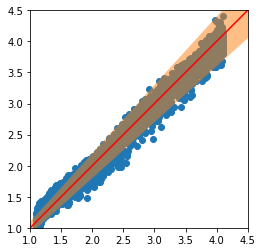

In [22]:
import matplotlib.pyplot as plt

plt.scatter( all_beta,  tf_predicted_data )
plt.plot( range(1,6), range(1,6), color='r' )

beta_range = numpy.arange(1,6)
plt.fill_between( beta_range , 0.9*beta_range , 1.1*beta_range, alpha = 0.5  )
plt.xlim(1,4.5)
plt.ylim(1,4.5)
plt.axes().set_aspect('equal')


(array([3.000e+00, 2.600e+01, 8.500e+01, 4.510e+02, 6.655e+03, 6.552e+03,
        1.724e+03, 6.670e+02, 1.860e+02, 3.500e+01]),
 array([-0.23076266, -0.18597467, -0.14118668, -0.0963987 , -0.05161071,
        -0.00682272,  0.03796526,  0.08275325,  0.12754123,  0.17232922,
         0.21711721]),
 <a list of 10 Patch objects>)

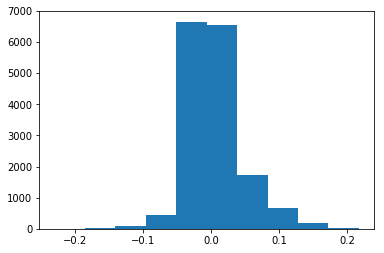

In [23]:
plt.hist( (tf_predicted_data - all_beta) / all_beta )


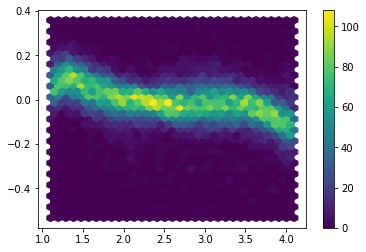

In [25]:

plt.hexbin( all_beta,  (tf_predicted_data - all_beta), gridsize=32  )
plt.colorbar()

In [ ]:

# this might be of use
# CNN with different kernel size
# physically, it retrieve information of different scale from the input layer!
# http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

